# Probabilistic Autoencoder on LHCO data

## Import machine lerning libraries

In [1]:
import sys
import numpy as np

sys.path.append("../")

from pae.models.autoencoder import DenseAutoencoder
from pae.models.flows import MAF
from pae.models.nn import PaeBuilder

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


2022-02-17 02:32:19.466141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 02:32:20.790349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-02-17 02:32:20.791890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30997 MB memory:  -> device: 1, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

# SEED = 100
# np.random.seed(SEED) 
# tf.random.set_seed(SEED)

tensorflow 2.6.0
tensorflow-probability 0.14.0
Available devices: CPU GPU GPU


## Plotting libraries 

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected = True)
pio.templates.default = "plotly_dark"
pio.templates.default = "presentation"

## Data loading and preprocessing

In [5]:
from pae.utils import load_json, dump_json

from pae.loaders.LHCO import ScalarLoaderLHCO, DatasetBuilder

x = ScalarLoaderLHCO.from_json("../pae/configs/loader/rnd_scalar_2j.json")
mjj = ScalarLoaderLHCO.from_json("../pae/configs/loader/rnd_scalar_mjj.json")
builder = DatasetBuilder(x, mjj)
builder.data_preparation(sample_sizes ={'sig':1_000, 'bkg': 200_000}, fit_key='bkg')
dataset = builder.make_dataset(train = {'bkg':100_000}, test={'sig':1000, 'bkg': 100_000})

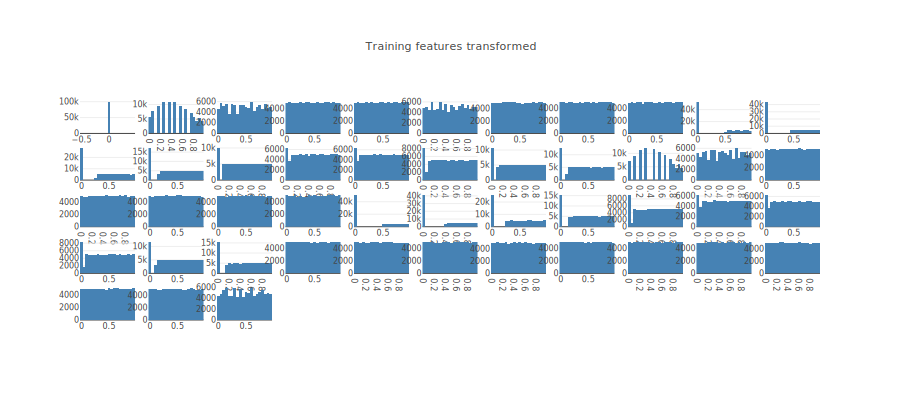

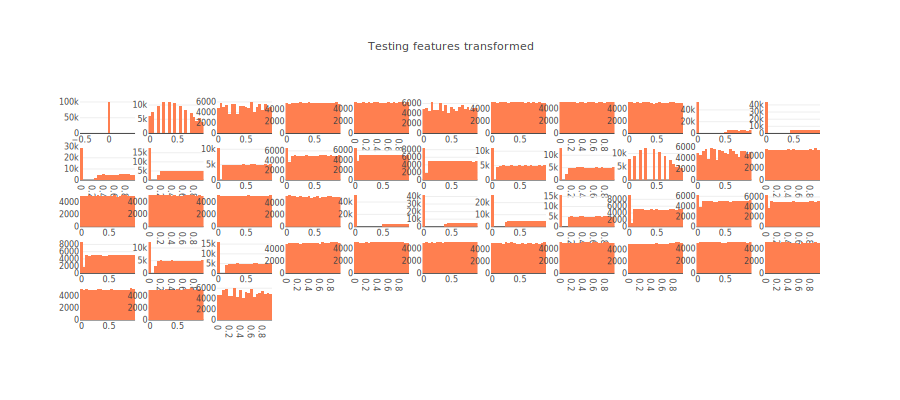

In [6]:
import sys
from pae.plotting import feature_plots
sys.path.append('..')

fig = feature_plots(dataset['x_train'], 'dijet')
fig.update_layout(title="Training features transformed")
fig.show('svg')
fig = feature_plots(dataset['x_test'], 'dijet', color='coral')
fig.update_layout(title="Testing features transformed")
fig.show('svg')

## Density estimation of $m_{jj}$

In [7]:
from pae.density import GMM, ConvKDE, KNNDensity, ExpnormFit

fit_data = dataset["mjj_train"]

gmm = GMM(n_components=200, covariance_type='full', max_iter=1_000, n_init=5)
gmm.fit(fit_data)
#y_gmm = gmm.evaluate(fit_data)

fftkde = ConvKDE(bw="silverman", kernel="box")
fftkde.fit(fit_data)
#y_kde = fftkde.evaluate(fit_data)

knn = KNNDensity()
knn.fit(fit_data)
#y_knn = knn.evaluate(fit_data)

expn = ExpnormFit()
expn.fit(fit_data)

In [8]:
x_ref = np.linspace(1600, 8000, 1701)
y_gmm = gmm.evaluate(x_ref)
y_kde = fftkde.evaluate(x_ref)
y_knn = knn.evaluate(x_ref)
y_exp = expn.evaluate(x_ref)

$$m_{jj}$$

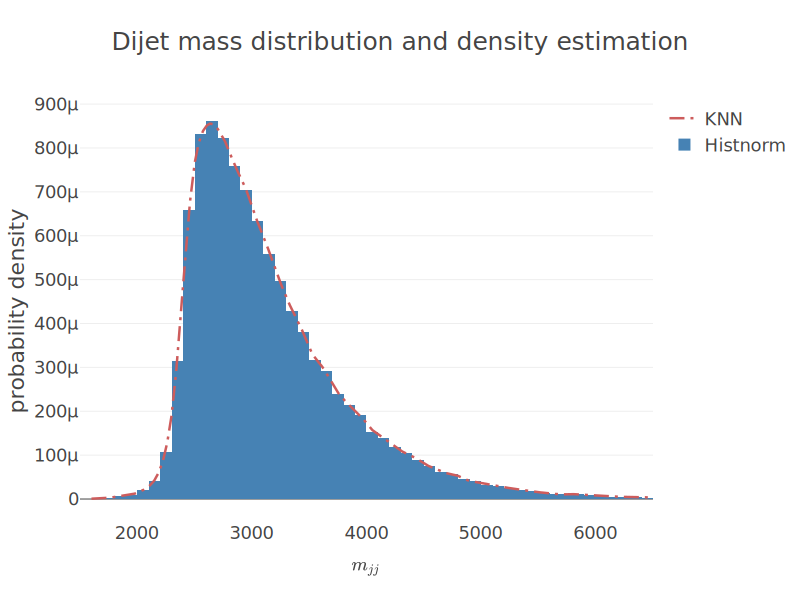

In [9]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=x_ref, y=y_gmm, mode='lines', name='GMM',
#                          line={'color': 'greenyellow', 'width': 2, 'dash': 'dot'}))
# fig.add_trace(go.Scatter(x=x_ref, y=y_kde, mode='lines', name='FFTKDE',
#                          line={'color': 'turquoise', 'width': 2, 'dash': 'dash'}))
fig.add_trace(go.Scatter(x=x_ref, y=y_knn, mode='lines', name='KNN',
                         line={'color': 'indianred', 'width': 2.5, 'dash': 'longdashdot'}))
# fig.add_trace(go.Scatter(x=x_ref, y=y_exp, mode='lines', name='expnorm',
#                          line={'color': 'indigo', 'width': 2, 'dash': 'solid'}))
fig.add_trace(go.Histogram(x=dataset["mjj_train"].ravel(), nbinsx=100, histnorm='probability density', 
                           marker_color='steelblue', name='Histnorm'))
fig.update_layout(
    title_text='Dijet mass distribution and density estimation',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'probability density',
    width=800,
    height=600,
    xaxis_range=[1500,6500]
)
fig.write_image("mjj.pdf")
fig.show('svg')

### Computing Weights

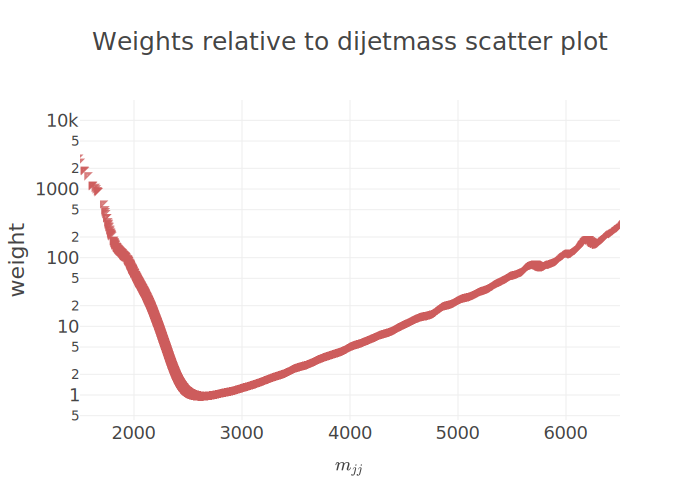

In [10]:
data = dataset['mjj_train'].ravel()

data_key = 'mjj_train'

w_gmm = gmm.get_weights(dataset[data_key])
w_kde = fftkde.get_weights(dataset[data_key])
w_expnorm = expn.get_weights(dataset[data_key])
w_knn = knn.get_weights(dataset[data_key])
fig = go.Figure()
# fig.add_trace(go.Scattergl(x=data, y=w_gmm, 
#                            mode='markers', name='GMM', opacity=0.8,
#                            marker=dict(color='greenyellow',symbol='diamond'))
#             )
# fig.add_trace(go.Scattergl(x=data, y=w_kde, 
#                            mode='markers', name='FFTKDE', opacity=0.8,
#                            marker=dict(color='indianred',symbol='star-square'))
#             )
# fig.add_trace(go.Scattergl(x=data, y=w_expnorm, 
#                            mode='markers', name='expnorm', opacity=0.8,
#                            marker=dict(color='indigo',symbol='circle'))
#             )
fig.add_trace(go.Scattergl(x=data, y=w_knn, 
                           mode='markers', name='KNN', opacity=0.8,
                           marker=dict(color='indianred',symbol='triangle-nw-dot'))
            )
fig.update_layout(
    title_text='Weights relative to dijetmass scatter plot',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'weight',
    yaxis_type="log",
    xaxis_range=[1500,6500]
)
fig.write_image("mjj_w.pdf")
fig.show('svg')

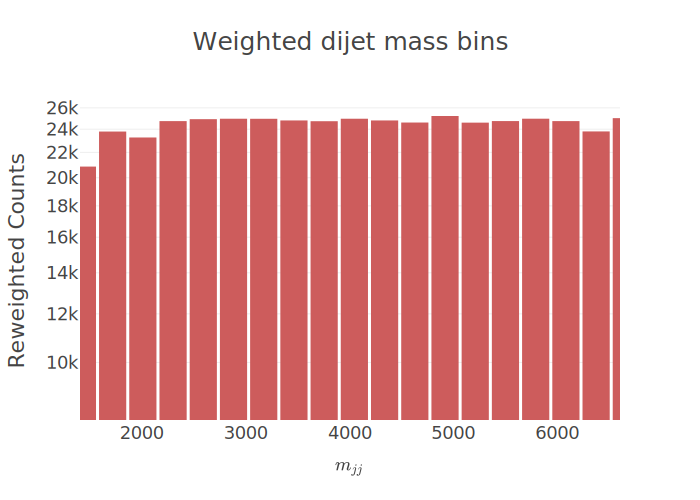

In [11]:
n_kde, b = np.histogram(data, bins=27, weights=w_kde)
n_gmm, _ = np.histogram(data, bins=b, weights=w_gmm)
n_exp, _ = np.histogram(data, bins=b, weights=w_expnorm)
n_knn, _ = np.histogram(data, bins=b, weights=w_knn)
fig = go.Figure()       
# fig.add_trace(go.Bar(x=b[:-1], y=n_kde, name='FFTKDE',
#                            marker=dict(color='indianred'))
#             )
# fig.add_trace(go.Bar(x=b[:-1], y=n_gmm, name='GMM',
#                         marker=dict(color='yellowgreen'))
#             )
# fig.add_trace(go.Bar(x=b[:-1], y=n_exp, name='expnorm',
#                         marker=dict(color='indigo'))
#             )
fig.add_trace(go.Bar(x=b[:-1], y=n_knn, name='KNN',
                        marker=dict(color='indianred'))
            )
fig.update_layout(
    title_text=r'Weighted dijet mass bins',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'Reweighted Counts',
    yaxis_type="log",
    bargap=0.1,
    xaxis_range=[1400,6600]
)
fig.write_image("mjj_r.pdf")
fig.show('svg')

## Network creation

In [12]:
# from models import OPTIMIZERS, ACTIVATIONS, REGULARIZERS, MODELS, CALLBACKS
# pae_config = {
#     'ae_model': 'dense_ae',
#     'nf_model': 'maf',
#     'AE:input_dim': 47,
#     'AE:encoding_dim': 10,
#     'AE:units': [30, 20 ,15],
#     'AE:hidden_activation': 'relu',
#     'AE:output_activation': 'sigmoid',
#     'AE:weight_reg': {'l1': 1e-6},
#     'AE:bias_reg': {},
#     'AE:output_reg': {},
#     'NF:n_dims': 10,
#     'NF:n_layers':5, 
#     'NF:units':[32 for i in range(4)]
#     'ae_optimizer': 'adam',
#     'nf_optimizer': 'adam',
#     'ae_optim_kwargs': dict(lr=0.05),
#     'nf_optim_kwargs': dict(lr=0.005),
#     # 'ae_callbacks': ['reduce_lr_on_plateau']
#     # 'ae_callbacks_kwargs': [dict(factor=0.2, patience=10, verbose=1)]
#     # 'nf_callbacks': ['reduce_lr_on_plateau']
#     # 'nf_callbacks_kwargs': [dict(factor=0.2, patience=5, verbose=1)]
# }

In [13]:
builder = PaeBuilder()

ae_config = {
    'input_dim':47, 
    'encoding_dim':10, 
    'units':[30, 20, 15],
    'weight_reg':tfk.regularizers.L1L2(l1=1e-5, l2=1e-4),
    'output_activation':tf.nn.sigmoid
}
nf_config = {
    'n_dims':10, 
    'n_layers':5, 
    'units':[32 for _ in range(4)]
}
optimizer_ae = {
    'learning_rate': 0.001
}
optimizer_nf = {
    'learning_rate': 0.005
}

builder.make_ae_model(DenseAutoencoder, ae_config)
builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae()
builder.compile_nf()
pae = builder.pae

In [14]:
from sklearn.model_selection import KFold

fold5 = KFold(8, shuffle=True)
q= fold5.split(dataset["x_train"])
x_train, x_valid = next(q)
print(x_train.shape)
print(x_valid.shape)

(87500,)
(12500,)


In [15]:
#w_kde_valid = fftkde.get_weights(dataset["x_train"][x_valid])
# w_gmm_valid = gmm.get_weights(dataset["x_train"][x_valid])

weights = w_knn

ae_train ={
    'batch_size':200,
    'epochs':120,
    'sample_weight':weights[x_train],
    'validation_data':(dataset["x_train"][x_valid],dataset["x_train"][x_valid], weights[x_valid]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=10,
        verbose=1
    ),
    "verbose":0
}

nf_train ={
    'batch_size':200,
    'epochs':80,
    'validation_data':(dataset["x_train"][x_valid],dataset["x_train"][x_valid]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    ),
    "verbose":0
}
with tf.device("/device:GPU:0"):
    %time pae.fit(dataset["x_train"][x_train],None,ae_train,nf_train)


2022-02-17 02:36:24.228696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2022-02-17 02:39:47.099721: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 3.9999996079131965e-05.
CPU times: user 14min 52s, sys: 1min 5s, total: 15min 57s
Wall time: 11min 36s


In [16]:
# pae.ae.save_weights("./save_testing/ae.h5")
# pae.nf.save_weights("./save_testing/nf.h5")


OSError: Unable to create file (unable to open file: name = './save_testing/ae.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Training metrics

In [ ]:
from pae.plotting import loss_plot

fig = loss_plot(pae.history)
fig.show('svg')

In [ ]:
# builder = PaeBuilder()
# builder.make_ae_model(DenseAutoencoder, ae_config)
# builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
# builder.make_nf_model(MAF, nf_config)
# builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
# builder.compile_ae()
# builder.compile_nf()
# pae = builder.pae
# pae.ae(np.zeros(47).reshape(1,-1))
# pae.nf(np.zeros(10).reshape(1,-1))
# pae.ae.load_weights("./save_testing/ae.h5")
# pae.nf.load_weights("./save_testing/nf.h5")

In [ ]:
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

In [ ]:
from pae.plotting import latent_space_plot

fig = latent_space_plot(z_true, z_sample)
fig.show('svg')

## Analysis

In [ ]:
import tensorflow_probability as tfp
import tqdm
import os
from concurrent.futures import ProcessPoolExecutor 
tfd = tfp.distributions
pae.compute_implicit_sigma(dataset['x_train'][x_valid])

sigma = tf.constant(tf.sqrt(pae.sigma_square))
z_ = tf.Variable(pae.ae.encoder(dataset['x_train'][0].reshape(1,-1)))
opt = tf.optimizers.Adam(learning_rate=0.001)
STEPS = 300
z_test = []

@tf.function
def max_apriori_prob(x, z, sigma, pae):
    dist = tfd.MultivariateNormalDiag(loc=x, scale_diag=sigma)
    nf_ll = pae.nf(z)
    reco = pae.ae.decoder(z)
    gauss_ll = dist.log_prob(reco)
    #tf.print("gauss:", gaussll, "nf:", nfll, "\n")
    return  -nf_ll - gauss_ll 


@tf.function
def find_map(x):
    x_ = tf.reshape(x, (1,-1))
    global z_
    if z_ is None:
        z_ = tf.Variable(pae.ae.encoder(x_))
    z_.assign(pae.ae.encoder(x_))
    for _ in range(STEPS):
        with tf.GradientTape() as tape:
            tape.watch(z_)
            nll = max_apriori_prob(x_, z_, sigma, pae)
        grad = tape.gradient(nll, [z_])
        opt.apply_gradients(zip(grad, [z_]))
    return z_

@tf.function
def tf_graph_map(*args, **kwargs):
    return tf.map_fn(*args, **kwargs)

In [ ]:
%%time
with tf.device("GPU:0"):
    x_test = tf.constant(dataset['x_test'][:10].astype(np.float32))
    z_map = tf_graph_map(find_map, x_test, parallel_iterations=1000)

In [ ]:
print(z_map.shape)

In [ ]:
nll = np.concatenate(nll_list)

In [ ]:
fig = px.line(x=np.arange(len(nll_list)), y=nll)
fig.show()

In [ ]:
mse = pae.reco_error(dataset['x_train'][x_train])
pae.compute_implicit_sigma(dataset['x_train'][x_valid])
ascore = -pae.anomaly_score(dataset['x_train'][x_train])

In [ ]:
# test_fractions = {
#     'bkg':100_000,
#     'sig':1000
# }
test2 = dataset#loader.make_test(test_fractions, replace=False)#dataset

ascore = -pae.anomaly_score(test2['x_test'])
mse = pae.reco_error(test2['x_test'])

In [ ]:
x=test2['x_test']
mses = np.dot(np.square(pae.ae(x)-x),pae.sigma_square**(-1))
lp = np.exp(np.array(pae.log_prob_encoding(x)))
synergy= -np.sqrt(mse*lp)


# Load previous result

In [ ]:
# mjj = np.fromfile("figures/sig-inj/mjj.npy")
# ascore = np.fromfile("figures/sig-inj/ascore.npy", dtype=np.float32)
# import json

# with open("figures/sig-inj/labels.json", "r") as fp:
#     labels = json.load(fp)

In [ ]:
# ascore.tofile("./figures/sig-inj/ascore.npy")
# mjj.tofile("./figures/sig-inj/mjj.npy")

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

prc=90

x_min = np.percentile(ascore, 1)
x_max = np.percentile(ascore, 99)
x_prc = np.percentile(ascore, prc)
i_prc = (ascore >= x_prc)

fig = go.Figure(layout_xaxis_range=[-30,30])
fig.add_trace(go.Histogram(x=ascore, name='Test dataset',
                           marker_color='plum', nbinsx=200),
              )
fig.add_vline(x=x_prc, y1=5100, line_width=2, line_color='firebrick', 
              annotation_text=f"{prc}th percentile", 
              annotation_position="top right",
              )

fig.update_layout(
    xaxis_title='Anomaly Score',
    #title_text=r'Cut on Anomaly Score',
    margin={'l': 80, 'b': 40, 't': 40, 'r': 40},
    width=600, height=300,
    paper_bgcolor='rgba(0,0,0,1)',
        font=dict(size=18))
fig.write_image("./figures/ascore.svg")
fig.show('svg')


$m_{jj}$

In [ ]:
# import json

# with open("./figures/sig-inj/labels.json", "w") as fp:
#     json.dump(dict(labels=labels.tolist()),fp)
np.save

In [ ]:
def adj(x, prc_min=1, prc_max=99):
    xmin, xmax = np.percentile(x,prc_min), np.percentile(x,prc_max)
    return x[(x >= xmin) & (x<= xmax)]

In [ ]:
mjj=test2['mjj_test']


def binarize(label):
    return 1 if label == 'sig' else 0
labels = np.array(list(map(binarize, test2['labels_test'])))
sig_label = (labels==1)
bkg_label = (labels==0)

fig = go.Figure()
fig.add_trace(go.Histogram(x=adj(mjj[bkg_label].ravel()), name="SM - QCD",
                          marker_color='steelblue', nbinsx=150))
fig.add_trace(go.Histogram(x=mjj[sig_label][:2000].ravel(), name="BSM - Signal",
                          marker_color='darkorange'))
sb = 100*sum(sig_label)/sum(bkg_label)
fig.update_layout(
    xaxis_title=r'$m_{jj}$',
    title_text=f'Dijet mass spectrum',
    barmode='stack',
    legend = dict(x=0.78, y=1,
        traceorder='normal',
        font=dict(size=15)),
    paper_bgcolor='rgba(0,0,0,1)',
    width=800, height=500)

fig.show('svg')
fig.write_image("anomaly.pdf") 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=mjj[i_prc&bkg_label].ravel(), name="Full test bkg",
                          marker_color='steelblue', nbinsx=100))
fig.add_trace(go.Histogram(x=mjj[i_prc&sig_label].ravel(), name="Full test sig",
                          marker_color='darkorange'))
sb = 100*sum(i_prc&sig_label)/sum(i_prc&bkg_label)
fig.update_layout(
    xaxis_title='$m_{jj}$',
    title_text=f'Dijet mass spectrum after cut S/B={sb:.2f}%',
    width=600,
    barmode='stack'
    )
fig.show('svg')
fig.write_image("initial.svg") 

In [ ]:
print("Eff:",mjj[i_prc&sig_label].shape[0]/1000)
print("Rej:",1-mjj[i_prc&bkg_label].shape[0]/200_000)

In [ ]:
inrange = (mjj >= 2800) & (mjj <=4500)
fig = go.Figure()
fig.add_trace(go.Histogram(x=mjj[inrange].ravel(), name="Full Test Set", histnorm='probability density',
                          nbinsx=40, bingroup='1',
                          marker=dict(color='rgba(135, 206, 250, 0.0)', 
                                  line=dict(
                                        color='SteelBlue',
                                        width=2
            ))))
fig.add_trace(go.Histogram(x=mjj[inrange.ravel()&i_prc].ravel(), name="Events Left After Cut", opacity=0.5, nbinsx=40,
                          marker_color='darkorange', bingroup='1', histnorm='probability density',
                          marker=dict(line=dict(
                                        color='Tomato',
                                        width=2
            ))))
#sb = 100*sum(i_prc&sig_label)/sum(i_prc&bkg_label)
fig.update_layout(
    xaxis_title='$$m_{jj}$$',
    #title_text=f'Dijet mass spectra',
    margin={'l': 80, 'b': 40, 't': 40, 'r': 40},
    width=600, height=300,
    paper_bgcolor='rgba(0,0,0,1)',
        font=dict(size=18),
    barmode='overlay',
    legend = dict(x=0.6, y=0.95,
        traceorder='normal',
        font=dict(size=18)),
    )
fig.write_image("./figures/mjj_demo.svg")
fig.show('svg') 

In [ ]:
bkg = mjj.ravel()
data = mjj[i_prc].ravel()
weights = np.repeat(1/(bkg.shape[0]/data.shape[0]),bkg.shape[0])
#weights_k = np.repeat(1/(data.shape[0]/data2.shape[0]),data.shape[0])

In [ ]:
from pyBumpHunter import BumpHunter

hunter = BumpHunter(rang=(3000,4000),
                       width_min=2,
                       width_max=5,
                       width_step=1,
                       scan_step=1,
                       Npe=10000,
                       Nworker=1,
                       seed=666,
                       bins=50,
                       weights=weights,
                       useSideBand = True
                    )

# x_prc_50 = np.percentile(ascore_test, 50)

# high_prc = np.where(ascore_test >= x_prc_50)
# low_prc = np.where(ascore_test <= x_prc_50)

# data, bkg = test2['excl_test'][high_prc][:,0], test2['excl_test'][low_prc][:,0]

%time hunter.bump_scan(data,bkg)

In [ ]:
hunter.plot_bump(data,bkg)

In [ ]:
hunter.print_bump_true(data,bkg)

In [ ]:
import matplotlib.pyplot as plt

sig_mask = sig_label

hunter.min_loc_ar[0]
b = np.histogram_bin_edges(bkg, range=(3000,4000), bins=20)
fig = plt.figure(figsize=(12,8))
plt.hist([mjj[~sig_mask&i_prc].ravel(), mjj[sig_mask&i_prc].ravel()], bins=b, range=(3000,4000),label=["data(bkg)", "data(sig)"],stacked = True)
plt.hist(bkg, bins=b, range=(3000,4000), label="bkg(ref)",stacked = True, histtype='step', weights=weights)
plt.legend()
# line = plt.axvline(x=3520.000, color='red', linestyle="--")
# line.set_label('Label via method')
# plt.axvline(x=3580.000, color='red', linestyle="--")
plt.title("Distributions with bump")
plt.show()

## Plots

In [ ]:
from scipy.spatial.distance import jensenshannon

def mass_sculpting(mjj, score):
    max_prc = 99
    n_full, b = np.histogram(mjj, bins=60, density=True)
    js_div = {}
    for prc in range(1, max_prc+1):
        x_prc = np.percentile(score, prc)
        i_prc = np.where(score >= x_prc)[0]
        n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
        js_div[prc] = jensenshannon(n_full,n_prc)

    return js_div

def nmse(x, pae):
    reco_error = np.square(pae.ae(x)-x)
    return np.dot(reco_error,pae.sigma_square**(-1))


In [ ]:
js_div_nf = load_json("./nf-js.json")

In [ ]:
from scipy.spatial.distance import jensenshannon
pio.templates.default = "plotly_dark"
mjj = dataset['mjj_train']

score = pae.anomaly_score(dataset['x_train'])
js_div_pae = mass_sculpting(mjj,score)

score = nmse(dataset['x_train'], pae)
js_div_nmse = mass_sculpting(mjj,score)

score = pae.reco_error(dataset['x_train'])
js_div_mse = mass_sculpting(mjj,score)

score = -pae.log_prob_encoding(dataset['x_train'])
js_div_lpz = mass_sculpting(mjj,score)

fig = go.Figure()
# fig.add_shape(
#     type='line', line=dict(dash='dash', color="tomato", width=1),
#     x0=90, x1=90, y0=0, y1=0.04, 
# )

fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_nf.values()), mode='lines',
        name=r"$-\log p_x$", line=dict(color="rosybrown", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_lpz.values()), mode='lines',
        name=r"$-\log p_z$", line=dict(color="chocolate", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_mse.values()), mode='lines',
        name=r"$\text{MSE}$", line=dict(color="steelblue", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_nmse.values()), mode='lines',
        name=r"$\text{MSE} \cdot \sigma^{\circ-2}$", line=dict(color="cornflowerblue", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_pae.values()), mode='lines',
        name=r"$\text{PAE}$", line=dict(color="plum", width=3))
)



# fig.add_trace(go.Scatter(
#     x=[86],
#     y=[0.003],
#     mode="text",
#     text=["97th percentile"],
#     textposition="top center",
#     showlegend=False
# ))

fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=600, height=500,
    paper_bgcolor='rgba(0,0,0,1)',
        legend = dict(x=0, y=1,
        traceorder='normal',
        font=dict(size=15))
)
fig.show('svg')
fig.write_image("JS-plot.pdf")


In [ ]:
def make_trace(labels, score, c, n=""):
    fpr, tpr, _ = roc_curve(labels, score)
    aauc = auc(1-fpr, tpr)
    print(n,aauc)
    return go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=n+f"AUC:{aauc:.2f}", line=dict(color=c, width=2))

nf_roc = load_json("./nf-roc.json")

In [ ]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

def binarize(label):
    return 1 if label == 'sig' else 0
labels = np.array(list(map(binarize, test2['labels_test'])))

fpr, tpr, _ = roc_curve(labels, ascore)
pae_auc = auc(1-fpr, tpr)

score = pae.reco_error(dataset['x_test'])
roc_mse = make_trace(labels, score, 'steelblue')

score = nmse(dataset['x_test'], pae)
roc_nmse = make_trace(labels, score, 'cornflowerblue')

score = -pae.log_prob_encoding(dataset['x_test'])
roc_lpz = make_trace(labels, score, 'chocolate')

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=nf_roc["eff"], y=nf_roc["rej"], mode='lines',
        name=f"AUC:{nf_roc['auc']:.2f}", line=dict(color="rosybrown", width=2))
)

fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"AUC:{pae_auc:.2f}", line=dict(color="Plum", width=2))
)

fig.add_trace(roc_mse)
fig.add_trace(roc_nmse)
fig.add_trace(roc_lpz)
fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.1, y=0.05,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves",
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,1)',
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.write_image("ROC2jet.pdf")
fig.show("svg")